In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt

% matplotlib inline

In [3]:
import keras

Using TensorFlow backend.


In [4]:
from keras.layers import Input
from keras.layers import concatenate, add
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.core import Flatten, Dense

from keras.models import Model
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta

def vgg_separate_channels(num_classes, optimizer, include_dense=False):
    """VGG inspired Convolutional Networks with multiple inputs
    
    Parameters
    ----------
    num_classes : int
        Number of classes to predict
            
    optimizer : keras.optimizers.Optimizer
        Instance of Keras optimizer to attach to the resulting network
        
    include_dense : bool (default False)
        Flag indicating wether to include a Dense Layer at the top 
        of each separate vgg-like sub-network.
    """
    
    def _conv_block(input_layer, include_dense=False):
        """VGG-inspired Convolutional Blocks"""
        
        prefix = input_layer.name.split('_')[0]

        # Block 1
        x = Conv2D(32, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block1_conv1'.format(prefix))(input_layer)
        
        x = Conv2D(32, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block1_conv2'.format(prefix))(x)
        
        x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), 
                         padding='same', name='{}_block1_pool'.format(prefix))(x)

        # Block 2
        x = Conv2D(64, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block2_conv1'.format(prefix))(x)
        
        x = Conv2D(64, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block2_conv2'.format(prefix))(x)
        
        x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), 
                         padding='same', name='{}_block2_pool'.format(prefix))(x)

        # Block 3
        x = Conv2D(128, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block3_conv2'.format(prefix))(x)
        
        x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2), 
                             padding='same', name='{}_block3_pool'.format(prefix))(x)
        x = Flatten()(x)
        if include_dense:
            x = Dense(512)(x)
        return x


    ZT_SHAPE = (1, 75, 18)
    XY_SHAPE = (1, 16, 15)
    
    zt_layer = Input(shape=ZT_SHAPE, name='zt_input')
    xy_layer = Input(shape=XY_SHAPE, name='xy_input')
    
    zt_branch = _conv_block(zt_layer, include_dense)
    xy_branch = _conv_block(xy_layer, include_dense)
    
    # top
    if include_dense:
        x = add([zt_branch, xy_branch], name='merge_add')
    else:
        x = concatenate([zt_branch, xy_branch], name='merge_concat')
        
    x = Dense(256,activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=[zt_layer, xy_layer], outputs=predictions, name='vgglike')
    model.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
    return model

In [5]:
fnames_test = np.asarray(["train_test_files/Xy_test"+str(i+1)+"_sel5_updown.npz"for i in range(100)])
fnames_train = np.asarray(["train_test_files/Xy_train"+str(i+1)+"_sel5_updown.npz"for i in range(100)])
fnames_indx = np.asarray(["train_test_files/Xy_indx"+str(i+1)+"_sel5_updown.npz"for i in range(100)])

In [6]:
import get_iterations
reload(get_iterations)

<module 'get_iterations' from 'get_iterations.pyc'>

In [7]:
from get_iterations import get_n_iterations

In [8]:
n_files = 2

In [9]:
steps_per_epoch, n_train_events = get_n_iterations(fnames_train[:n_files], 32)
print(steps_per_epoch, n_train_events)

(96, 3067)


In [10]:
predict_steps, n_test_events = get_n_iterations(fnames_test[:n_files], 64)
print(predict_steps, n_test_events)

(12, 767)


In [12]:
#from multi_files_generator import Xy_gen_ZT_XY
import multi_files_generator

In [ ]:
b_size = 64
epochs = 40
fargs = {'num_classes': 2, 'optimizer': Adadelta()}
vgg_sep_model = vgg_separate_channels(**fargs)

fitargs = {'steps_per_epoch': steps_per_epoch, 'epochs': epochs, 'verbose': 1, 
           'callbacks': [keras.callbacks.TensorBoard(batch_size=b_size), 
                         keras.callbacks.ModelCheckpoint("models/vgg_sep_updown_"+str(n_files)+"files_"+str(b_size)+"_6x6_"+str(epochs)+"epochs.hdf5")]}
history_vgg_sep = vgg_sep_model.fit_generator(multi_files_generator.Xy_gen_ZT_XY_cont(fnames_train[:n_files], batch_size=b_size), **fitargs)


Epoch 1/40file 1 : train_test_files/Xy_train1_sel5_updown.npz



In [63]:
b_size = 64
epochs = 100
fargs = {'num_classes': 2, 'optimizer': Adadelta()}
vgg_sep_model = vgg_separate_channels(**fargs)

fitargs = {'steps_per_epoch': steps_per_epoch, 'epochs': epochs, 'verbose': 1, 
           'callbacks': [keras.callbacks.TensorBoard(batch_size=b_size), 
                         keras.callbacks.ModelCheckpoint("models/vgg_sep_updown_10files_"+str(b_size)+"_3x3_"+str(epochs)+"epochs.hdf5")]}
history_vgg_sep = vgg_sep_model.fit_generator(multi_files_generator.Xy_gen_ZT_XY(fnames_train[:10], batch_size=b_size), **fitargs)


file 1 : train_test_files/Xy_train1_sel5_updown.npzEpoch 1/100

 14/245 [>.............................] - ETA: 51s - loss: 0.6786 - acc: 0.553624
file 2 : train_test_files/Xy_train2_sel5_updown.npz
 39/245 [===>..........................] - ETA: 33s - loss: 0.6438 - acc: 0.618949
file 3 : train_test_files/Xy_train3_sel5_updown.npz
 64/245 [======>.......................] - ETA: 26s - loss: 0.6047 - acc: 0.645474
file 4 : train_test_files/Xy_train4_sel5_updown.npz
 88/245 [=========>....................] - ETA: 22s - loss: 0.5752 - acc: 0.667698
file 5 : train_test_files/Xy_train5_sel5_updown.npz
113/245 [============>.................] - ETA: 18s - loss: 0.5520 - acc: 0.6814123
file 6 : train_test_files/Xy_train6_sel5_updown.npz
138/245 [===============>..............] - ETA: 14s - loss: 0.5334 - acc: 0.6917148
file 7 : train_test_files/Xy_train7_sel5_updown.npz
162/245 [==================>...........] - ETA: 11s - loss: 0.5175 - acc: 0.7012172
file 8 : train_test_files/Xy_train8_sel5

186/245 [=====================>........] - ETA: 7s - loss: 0.3658 - acc: 0.7683196
file 9 : train_test_files/Xy_train9_sel5_updown.npz
211/245 [========================>.....] - ETA: 4s - loss: 0.3655 - acc: 0.7690221
file 10 : train_test_files/Xy_train10_sel5_updown.npz
235/245 [===========================>..] - ETA: 1s - loss: 0.3662 - acc: 0.7707245
file 1 : train_test_files/Xy_train1_sel5_updown.npz
245/245 [==============================] - 30s - loss: 0.3662 - acc: 0.7707    
Epoch 7/100
 14/245 [>.............................] - ETA: 40s - loss: 0.3596 - acc: 0.769024
file 2 : train_test_files/Xy_train2_sel5_updown.npz
 39/245 [===>..........................] - ETA: 29s - loss: 0.3648 - acc: 0.764449
file 3 : train_test_files/Xy_train3_sel5_updown.npz
 64/245 [======>.......................] - ETA: 24s - loss: 0.3671 - acc: 0.768374
file 4 : train_test_files/Xy_train4_sel5_updown.npz
 88/245 [=========>....................] - ETA: 20s - loss: 0.3651 - acc: 0.769598
file 5 : trai

245/245 [==============================] - 30s - loss: 0.3440 - acc: 0.7806    
Epoch 18/100
 14/245 [>.............................] - ETA: 39s - loss: 0.3387 - acc: 0.777924
file 2 : train_test_files/Xy_train2_sel5_updown.npz
 39/245 [===>..........................] - ETA: 29s - loss: 0.3466 - acc: 0.774449
file 3 : train_test_files/Xy_train3_sel5_updown.npz
 64/245 [======>.......................] - ETA: 24s - loss: 0.3496 - acc: 0.776374
file 4 : train_test_files/Xy_train4_sel5_updown.npz
 88/245 [=========>....................] - ETA: 21s - loss: 0.3457 - acc: 0.775798
file 5 : train_test_files/Xy_train5_sel5_updown.npz
113/245 [============>.................] - ETA: 17s - loss: 0.3469 - acc: 0.7768123
file 6 : train_test_files/Xy_train6_sel5_updown.npz
138/245 [===============>..............] - ETA: 13s - loss: 0.3453 - acc: 0.7780148
file 7 : train_test_files/Xy_train7_sel5_updown.npz
162/245 [==================>...........] - ETA: 10s - loss: 0.3436 - acc: 0.7788172
file 8 : tr

 64/245 [======>.......................] - ETA: 24s - loss: 0.3381 - acc: 0.788474
file 4 : train_test_files/Xy_train4_sel5_updown.npz
 88/245 [=========>....................] - ETA: 21s - loss: 0.3351 - acc: 0.786598
file 5 : train_test_files/Xy_train5_sel5_updown.npz
113/245 [============>.................] - ETA: 17s - loss: 0.3362 - acc: 0.7860123
file 6 : train_test_files/Xy_train6_sel5_updown.npz
138/245 [===============>..............] - ETA: 14s - loss: 0.3346 - acc: 0.7867148
file 7 : train_test_files/Xy_train7_sel5_updown.npz
162/245 [==================>...........] - ETA: 10s - loss: 0.3330 - acc: 0.7877172
file 8 : train_test_files/Xy_train8_sel5_updown.npz
186/245 [=====================>........] - ETA: 7s - loss: 0.3322 - acc: 0.7885196
file 9 : train_test_files/Xy_train9_sel5_updown.npz
211/245 [========================>.....] - ETA: 4s - loss: 0.3319 - acc: 0.7890221
file 10 : train_test_files/Xy_train10_sel5_updown.npz
235/245 [===========================>..] - ETA: 1s

138/245 [===============>..............] - ETA: 14s - loss: 0.3221 - acc: 0.7959148
file 7 : train_test_files/Xy_train7_sel5_updown.npz
162/245 [==================>...........] - ETA: 10s - loss: 0.3207 - acc: 0.7976172
file 8 : train_test_files/Xy_train8_sel5_updown.npz
186/245 [=====================>........] - ETA: 7s - loss: 0.3203 - acc: 0.7980196
file 9 : train_test_files/Xy_train9_sel5_updown.npz
211/245 [========================>.....] - ETA: 4s - loss: 0.3201 - acc: 0.7978221
file 10 : train_test_files/Xy_train10_sel5_updown.npz
235/245 [===========================>..] - ETA: 1s - loss: 0.3207 - acc: 0.7971245
file 1 : train_test_files/Xy_train1_sel5_updown.npz
245/245 [==============================] - 31s - loss: 0.3197 - acc: 0.7986    
Epoch 41/100
 14/245 [>.............................] - ETA: 40s - loss: 0.3096 - acc: 0.806924
file 2 : train_test_files/Xy_train2_sel5_updown.npz
 39/245 [===>..........................] - ETA: 29s - loss: 0.3224 - acc: 0.799849
file 3 : t

211/245 [========================>.....] - ETA: 4s - loss: 0.3065 - acc: 0.8111221
file 10 : train_test_files/Xy_train10_sel5_updown.npz
235/245 [===========================>..] - ETA: 1s - loss: 0.3074 - acc: 0.8101245
file 1 : train_test_files/Xy_train1_sel5_updown.npz
245/245 [==============================] - 31s - loss: 0.3059 - acc: 0.8116    
Epoch 52/100
 14/245 [>.............................] - ETA: 39s - loss: 0.2838 - acc: 0.824824
file 2 : train_test_files/Xy_train2_sel5_updown.npz
 39/245 [===>..........................] - ETA: 29s - loss: 0.3023 - acc: 0.814949
file 3 : train_test_files/Xy_train3_sel5_updown.npz
 64/245 [======>.......................] - ETA: 24s - loss: 0.3035 - acc: 0.814074
file 4 : train_test_files/Xy_train4_sel5_updown.npz
 88/245 [=========>....................] - ETA: 21s - loss: 0.3056 - acc: 0.810698
file 5 : train_test_files/Xy_train5_sel5_updown.npz
113/245 [============>.................] - ETA: 17s - loss: 0.3040 - acc: 0.8129123
file 6 : tr

 14/245 [>.............................] - ETA: 39s - loss: 0.2605 - acc: 0.848224
file 2 : train_test_files/Xy_train2_sel5_updown.npz
 39/245 [===>..........................] - ETA: 29s - loss: 0.2816 - acc: 0.836149
file 3 : train_test_files/Xy_train3_sel5_updown.npz
 64/245 [======>.......................] - ETA: 24s - loss: 0.2835 - acc: 0.835374
file 4 : train_test_files/Xy_train4_sel5_updown.npz
 88/245 [=========>....................] - ETA: 21s - loss: 0.2875 - acc: 0.827598
file 5 : train_test_files/Xy_train5_sel5_updown.npz
113/245 [============>.................] - ETA: 17s - loss: 0.2853 - acc: 0.8311123
file 6 : train_test_files/Xy_train6_sel5_updown.npz
138/245 [===============>..............] - ETA: 14s - loss: 0.2871 - acc: 0.8302148
file 7 : train_test_files/Xy_train7_sel5_updown.npz
162/245 [==================>...........] - ETA: 10s - loss: 0.2867 - acc: 0.8314172
file 8 : train_test_files/Xy_train8_sel5_updown.npz
186/245 [=====================>........] - ETA: 7s -

 88/245 [=========>....................] - ETA: 21s - loss: 0.2710 - acc: 0.841398
file 5 : train_test_files/Xy_train5_sel5_updown.npz
113/245 [============>.................] - ETA: 17s - loss: 0.2701 - acc: 0.8444123
file 6 : train_test_files/Xy_train6_sel5_updown.npz
138/245 [===============>..............] - ETA: 14s - loss: 0.2720 - acc: 0.8422148
file 7 : train_test_files/Xy_train7_sel5_updown.npz
162/245 [==================>...........] - ETA: 10s - loss: 0.2702 - acc: 0.8454172
file 8 : train_test_files/Xy_train8_sel5_updown.npz
186/245 [=====================>........] - ETA: 7s - loss: 0.2693 - acc: 0.8456196
file 9 : train_test_files/Xy_train9_sel5_updown.npz
211/245 [========================>.....] - ETA: 4s - loss: 0.2713 - acc: 0.8417221
file 10 : train_test_files/Xy_train10_sel5_updown.npz
235/245 [===========================>..] - ETA: 1s - loss: 0.2724 - acc: 0.8411245
file 1 : train_test_files/Xy_train1_sel5_updown.npz
245/245 [==============================] - 31s - l

245/245 [==============================] - 31s - loss: 0.2667 - acc: 0.8482    
Epoch 80/100
 14/245 [>.............................] - ETA: 39s - loss: 0.2525 - acc: 0.859424
file 2 : train_test_files/Xy_train2_sel5_updown.npz
 39/245 [===>..........................] - ETA: 29s - loss: 0.2623 - acc: 0.852649
file 3 : train_test_files/Xy_train3_sel5_updown.npz
 64/245 [======>.......................] - ETA: 25s - loss: 0.2619 - acc: 0.853474
file 4 : train_test_files/Xy_train4_sel5_updown.npz
 88/245 [=========>....................] - ETA: 21s - loss: 0.2679 - acc: 0.847298
file 5 : train_test_files/Xy_train5_sel5_updown.npz
113/245 [============>.................] - ETA: 17s - loss: 0.2663 - acc: 0.8517123
file 6 : train_test_files/Xy_train6_sel5_updown.npz
138/245 [===============>..............] - ETA: 14s - loss: 0.2684 - acc: 0.8491148
file 7 : train_test_files/Xy_train7_sel5_updown.npz
162/245 [==================>...........] - ETA: 10s - loss: 0.2646 - acc: 0.8526172
file 8 : tr

 64/245 [======>.......................] - ETA: 24s - loss: 0.2522 - acc: 0.859774
file 4 : train_test_files/Xy_train4_sel5_updown.npz
 88/245 [=========>....................] - ETA: 21s - loss: 0.2542 - acc: 0.857998
file 5 : train_test_files/Xy_train5_sel5_updown.npz
113/245 [============>.................] - ETA: 17s - loss: 0.2534 - acc: 0.8637123
file 6 : train_test_files/Xy_train6_sel5_updown.npz
138/245 [===============>..............] - ETA: 14s - loss: 0.2557 - acc: 0.8602148
file 7 : train_test_files/Xy_train7_sel5_updown.npz
162/245 [==================>...........] - ETA: 10s - loss: 0.2520 - acc: 0.8617172
file 8 : train_test_files/Xy_train8_sel5_updown.npz
186/245 [=====================>........] - ETA: 7s - loss: 0.2517 - acc: 0.8606196
file 9 : train_test_files/Xy_train9_sel5_updown.npz
211/245 [========================>.....] - ETA: 4s - loss: 0.2549 - acc: 0.8563221
file 10 : train_test_files/Xy_train10_sel5_updown.npz
235/245 [===========================>..] - ETA: 1s

In [52]:
model=keras.models.load_model("models/vgg_sep_updown_10files_64_6x6_100epochs.hdf5")

In [53]:
history_100_200 = model.fit_generator(multi_files_generator.Xy_gen_ZT_XY(fnames_train[:10], batch_size=b_size), **fitargs)

file 1 : train_test_files/Xy_train1_sel5_updown.npzEpoch 1/100

 14/245 [>.............................] - ETA: 65s - loss: 0.2697 - acc: 0.825924
file 2 : train_test_files/Xy_train2_sel5_updown.npz
 39/245 [===>..........................] - ETA: 43s - loss: 0.2759 - acc: 0.847949
file 3 : train_test_files/Xy_train3_sel5_updown.npz
 64/245 [======>.......................] - ETA: 34s - loss: 0.2724 - acc: 0.841974
file 4 : train_test_files/Xy_train4_sel5_updown.npz
 88/245 [=========>....................] - ETA: 29s - loss: 0.2763 - acc: 0.831198
file 5 : train_test_files/Xy_train5_sel5_updown.npz
113/245 [============>.................] - ETA: 23s - loss: 0.2741 - acc: 0.8325123
file 6 : train_test_files/Xy_train6_sel5_updown.npz
138/245 [===============>..............] - ETA: 19s - loss: 0.2761 - acc: 0.8291148
file 7 : train_test_files/Xy_train7_sel5_updown.npz
162/245 [==================>...........] - ETA: 14s - loss: 0.2735 - acc: 0.8291172
file 8 : train_test_files/Xy_train8_sel5

 64/245 [======>.......................] - ETA: 32s - loss: 0.2570 - acc: 0.846374
file 4 : train_test_files/Xy_train4_sel5_updown.npz
 88/245 [=========>....................] - ETA: 27s - loss: 0.2624 - acc: 0.839798
file 5 : train_test_files/Xy_train5_sel5_updown.npz
113/245 [============>.................] - ETA: 23s - loss: 0.2600 - acc: 0.8389123
file 6 : train_test_files/Xy_train6_sel5_updown.npz
138/245 [===============>..............] - ETA: 18s - loss: 0.2641 - acc: 0.8370148
file 7 : train_test_files/Xy_train7_sel5_updown.npz
162/245 [==================>...........] - ETA: 14s - loss: 0.2656 - acc: 0.8349172
file 8 : train_test_files/Xy_train8_sel5_updown.npz
186/245 [=====================>........] - ETA: 10s - loss: 0.2650 - acc: 0.8340196
file 9 : train_test_files/Xy_train9_sel5_updown.npz
211/245 [========================>.....] - ETA: 5s - loss: 0.2605 - acc: 0.8381221
file 10 : train_test_files/Xy_train10_sel5_updown.npz
235/245 [===========================>..] - ETA: 1

235/245 [===========================>..] - ETA: 1s - loss: 0.2636 - acc: 0.8358245
file 1 : train_test_files/Xy_train1_sel5_updown.npz
245/245 [==============================] - 42s - loss: 0.2628 - acc: 0.8363    
Epoch 18/100
 14/245 [>.............................] - ETA: 45s - loss: 0.2567 - acc: 0.824824
file 2 : train_test_files/Xy_train2_sel5_updown.npz
 39/245 [===>..........................] - ETA: 37s - loss: 0.2929 - acc: 0.809149
file 3 : train_test_files/Xy_train3_sel5_updown.npz
 64/245 [======>.......................] - ETA: 32s - loss: 0.2737 - acc: 0.829374
file 4 : train_test_files/Xy_train4_sel5_updown.npz
 88/245 [=========>....................] - ETA: 27s - loss: 0.2737 - acc: 0.827698
file 5 : train_test_files/Xy_train5_sel5_updown.npz
113/245 [============>.................] - ETA: 23s - loss: 0.2714 - acc: 0.8310123
file 6 : train_test_files/Xy_train6_sel5_updown.npz
138/245 [===============>..............] - ETA: 18s - loss: 0.2754 - acc: 0.8304148
file 7 : tra

 39/245 [===>..........................] - ETA: 38s - loss: 0.2719 - acc: 0.830549
file 3 : train_test_files/Xy_train3_sel5_updown.npz
 64/245 [======>.......................] - ETA: 32s - loss: 0.2874 - acc: 0.813374
file 4 : train_test_files/Xy_train4_sel5_updown.npz
 88/245 [=========>....................] - ETA: 28s - loss: 0.2812 - acc: 0.820598
file 5 : train_test_files/Xy_train5_sel5_updown.npz
113/245 [============>.................] - ETA: 23s - loss: 0.2809 - acc: 0.8237123
file 6 : train_test_files/Xy_train6_sel5_updown.npz
138/245 [===============>..............] - ETA: 19s - loss: 0.2807 - acc: 0.8232148
file 7 : train_test_files/Xy_train7_sel5_updown.npz
162/245 [==================>...........] - ETA: 14s - loss: 0.2785 - acc: 0.8237172
file 8 : train_test_files/Xy_train8_sel5_updown.npz
186/245 [=====================>........] - ETA: 10s - loss: 0.2754 - acc: 0.8244196
file 9 : train_test_files/Xy_train9_sel5_updown.npz
211/245 [========================>.....] - ETA: 5s 

211/245 [========================>.....] - ETA: 5s - loss: 0.2624 - acc: 0.8355221
file 10 : train_test_files/Xy_train10_sel5_updown.npz
235/245 [===========================>..] - ETA: 1s - loss: 0.2621 - acc: 0.8355245
file 1 : train_test_files/Xy_train1_sel5_updown.npz
245/245 [==============================] - 42s - loss: 0.2628 - acc: 0.8343    
Epoch 35/100
 14/245 [>.............................] - ETA: 46s - loss: 0.2812 - acc: 0.839324
file 2 : train_test_files/Xy_train2_sel5_updown.npz
 39/245 [===>..........................] - ETA: 38s - loss: 0.2784 - acc: 0.829149
file 3 : train_test_files/Xy_train3_sel5_updown.npz
 64/245 [======>.......................] - ETA: 32s - loss: 0.2767 - acc: 0.824474
file 4 : train_test_files/Xy_train4_sel5_updown.npz
 88/245 [=========>....................] - ETA: 28s - loss: 0.2716 - acc: 0.835998
file 5 : train_test_files/Xy_train5_sel5_updown.npz
113/245 [============>.................] - ETA: 23s - loss: 0.2697 - acc: 0.8391123
file 6 : tr

 14/245 [>.............................] - ETA: 47s - loss: 0.2637 - acc: 0.820324
file 2 : train_test_files/Xy_train2_sel5_updown.npz
 39/245 [===>..........................] - ETA: 38s - loss: 0.2601 - acc: 0.831349
file 3 : train_test_files/Xy_train3_sel5_updown.npz
 64/245 [======>.......................] - ETA: 32s - loss: 0.2631 - acc: 0.824274
file 4 : train_test_files/Xy_train4_sel5_updown.npz
 88/245 [=========>....................] - ETA: 28s - loss: 0.2624 - acc: 0.830598
file 5 : train_test_files/Xy_train5_sel5_updown.npz
113/245 [============>.................] - ETA: 23s - loss: 0.2609 - acc: 0.8360123
file 6 : train_test_files/Xy_train6_sel5_updown.npz
138/245 [===============>..............] - ETA: 18s - loss: 0.2567 - acc: 0.8356148
file 7 : train_test_files/Xy_train7_sel5_updown.npz
162/245 [==================>...........] - ETA: 14s - loss: 0.2567 - acc: 0.8340172
file 8 : train_test_files/Xy_train8_sel5_updown.npz
186/245 [=====================>........] - ETA: 10s 

186/245 [=====================>........] - ETA: 10s - loss: 0.2658 - acc: 0.8274196
file 9 : train_test_files/Xy_train9_sel5_updown.npz
211/245 [========================>.....] - ETA: 5s - loss: 0.2666 - acc: 0.8290221
file 10 : train_test_files/Xy_train10_sel5_updown.npz
235/245 [===========================>..] - ETA: 1s - loss: 0.2629 - acc: 0.8331245
file 1 : train_test_files/Xy_train1_sel5_updown.npz
245/245 [==============================] - 42s - loss: 0.2630 - acc: 0.8323    
Epoch 52/100
 14/245 [>.............................] - ETA: 46s - loss: 0.2655 - acc: 0.811424
file 2 : train_test_files/Xy_train2_sel5_updown.npz
 39/245 [===>..........................] - ETA: 37s - loss: 0.2588 - acc: 0.827449
file 3 : train_test_files/Xy_train3_sel5_updown.npz
 64/245 [======>.......................] - ETA: 32s - loss: 0.2628 - acc: 0.822174
file 4 : train_test_files/Xy_train4_sel5_updown.npz
 88/245 [=========>....................] - ETA: 27s - loss: 0.2670 - acc: 0.817998
file 5 : tr

245/245 [==============================] - 42s - loss: 0.2658 - acc: 0.8225    
Epoch 63/100
 14/245 [>.............................] - ETA: 46s - loss: 0.2644 - acc: 0.815824
file 2 : train_test_files/Xy_train2_sel5_updown.npz
 39/245 [===>..........................] - ETA: 37s - loss: 0.2587 - acc: 0.819149
file 3 : train_test_files/Xy_train3_sel5_updown.npz
 64/245 [======>.......................] - ETA: 32s - loss: 0.2644 - acc: 0.818374
file 4 : train_test_files/Xy_train4_sel5_updown.npz
 88/245 [=========>....................] - ETA: 27s - loss: 0.2675 - acc: 0.817098
file 5 : train_test_files/Xy_train5_sel5_updown.npz
113/245 [============>.................] - ETA: 23s - loss: 0.2695 - acc: 0.8189123
file 6 : train_test_files/Xy_train6_sel5_updown.npz
138/245 [===============>..............] - ETA: 18s - loss: 0.2707 - acc: 0.8196148
file 7 : train_test_files/Xy_train7_sel5_updown.npz
162/245 [==================>...........] - ETA: 14s - loss: 0.2678 - acc: 0.8212172
file 8 : tr

 64/245 [======>.......................] - ETA: 32s - loss: 0.2776 - acc: 0.816374
file 4 : train_test_files/Xy_train4_sel5_updown.npz
 88/245 [=========>....................] - ETA: 28s - loss: 0.2734 - acc: 0.815398
file 5 : train_test_files/Xy_train5_sel5_updown.npz
113/245 [============>.................] - ETA: 23s - loss: 0.2737 - acc: 0.8196123
file 6 : train_test_files/Xy_train6_sel5_updown.npz
138/245 [===============>..............] - ETA: 19s - loss: 0.2722 - acc: 0.8189148
file 7 : train_test_files/Xy_train7_sel5_updown.npz
162/245 [==================>...........] - ETA: 14s - loss: 0.2703 - acc: 0.8214172
file 8 : train_test_files/Xy_train8_sel5_updown.npz
186/245 [=====================>........] - ETA: 10s - loss: 0.2694 - acc: 0.8205196
file 9 : train_test_files/Xy_train9_sel5_updown.npz
211/245 [========================>.....] - ETA: 5s - loss: 0.2687 - acc: 0.8201221
file 10 : train_test_files/Xy_train10_sel5_updown.npz
235/245 [===========================>..] - ETA: 1

235/245 [===========================>..] - ETA: 1s - loss: 0.2609 - acc: 0.8166245
file 1 : train_test_files/Xy_train1_sel5_updown.npz
245/245 [==============================] - 42s - loss: 0.2607 - acc: 0.8180    
Epoch 80/100
 14/245 [>.............................] - ETA: 46s - loss: 0.2459 - acc: 0.833724
file 2 : train_test_files/Xy_train2_sel5_updown.npz
 39/245 [===>..........................] - ETA: 38s - loss: 0.2590 - acc: 0.817149
file 3 : train_test_files/Xy_train3_sel5_updown.npz
 64/245 [======>.......................] - ETA: 32s - loss: 0.2613 - acc: 0.819774
file 4 : train_test_files/Xy_train4_sel5_updown.npz
 88/245 [=========>....................] - ETA: 28s - loss: 0.2621 - acc: 0.817298
file 5 : train_test_files/Xy_train5_sel5_updown.npz
113/245 [============>.................] - ETA: 23s - loss: 0.2648 - acc: 0.8208123
file 6 : train_test_files/Xy_train6_sel5_updown.npz
138/245 [===============>..............] - ETA: 19s - loss: 0.2629 - acc: 0.8212148
file 7 : tra

 39/245 [===>..........................] - ETA: 38s - loss: 0.2595 - acc: 0.813549
file 3 : train_test_files/Xy_train3_sel5_updown.npz
 64/245 [======>.......................] - ETA: 32s - loss: 0.2577 - acc: 0.820174
file 4 : train_test_files/Xy_train4_sel5_updown.npz
 88/245 [=========>....................] - ETA: 28s - loss: 0.2586 - acc: 0.818498
file 5 : train_test_files/Xy_train5_sel5_updown.npz
113/245 [============>.................] - ETA: 23s - loss: 0.2612 - acc: 0.8192123
file 6 : train_test_files/Xy_train6_sel5_updown.npz
138/245 [===============>..............] - ETA: 18s - loss: 0.2602 - acc: 0.8184148
file 7 : train_test_files/Xy_train7_sel5_updown.npz
162/245 [==================>...........] - ETA: 14s - loss: 0.2587 - acc: 0.8201172
file 8 : train_test_files/Xy_train8_sel5_updown.npz
186/245 [=====================>........] - ETA: 10s - loss: 0.2582 - acc: 0.8201196
file 9 : train_test_files/Xy_train9_sel5_updown.npz
211/245 [========================>.....] - ETA: 5s 

211/245 [========================>.....] - ETA: 5s - loss: 0.2583 - acc: 0.8190221
file 10 : train_test_files/Xy_train10_sel5_updown.npz
235/245 [===========================>..] - ETA: 1s - loss: 0.2591 - acc: 0.8183245
file 1 : train_test_files/Xy_train1_sel5_updown.npz
245/245 [==============================] - 42s - loss: 0.2588 - acc: 0.8190    
Epoch 97/100
 14/245 [>.............................] - ETA: 46s - loss: 0.2464 - acc: 0.832624
file 2 : train_test_files/Xy_train2_sel5_updown.npz
 39/245 [===>..........................] - ETA: 37s - loss: 0.2634 - acc: 0.815149
file 3 : train_test_files/Xy_train3_sel5_updown.npz
 64/245 [======>.......................] - ETA: 32s - loss: 0.2614 - acc: 0.815874
file 4 : train_test_files/Xy_train4_sel5_updown.npz
 88/245 [=========>....................] - ETA: 27s - loss: 0.2608 - acc: 0.814898
file 5 : train_test_files/Xy_train5_sel5_updown.npz
113/245 [============>.................] - ETA: 23s - loss: 0.2622 - acc: 0.8196123
file 6 : tr

In [34]:
ytest = []
for i, (X_test, y_test) in enumerate(multi_files_generator.Xy_gen_ZT_XY(fnames_test)):
    ytest.append(y_test)
    if i==predict_steps-1:
        break
y_real = np.vstack(np.asarray(ytest))
y_real.shape

file 1 : train_test_files/Xy_test1_sel5_updown.npz
6
file 2 : train_test_files/Xy_test2_sel5_updown.npz
13
file 3 : train_test_files/Xy_test3_sel5_updown.npz
20
file 4 : train_test_files/Xy_test4_sel5_updown.npz
26
file 5 : train_test_files/Xy_test5_sel5_updown.npz
33
file 6 : train_test_files/Xy_test6_sel5_updown.npz
40
file 7 : train_test_files/Xy_test7_sel5_updown.npz
46
file 8 : train_test_files/Xy_test8_sel5_updown.npz
52
file 9 : train_test_files/Xy_test9_sel5_updown.npz
59
file 10 : train_test_files/Xy_test10_sel5_updown.npz


(3819, 2)

In [64]:
pred = vgg_sep_model.predict_generator(multi_files_generator.Xy_gen_ZT_XY(fnames_test), steps=predict_step)
ppred = np.vstack(pred)

predicted_y = np.argmax(pred, axis=1)
predicted_y.shape

file 1 : train_test_files/Xy_test1_sel5_updown.npz
6
file 2 : train_test_files/Xy_test2_sel5_updown.npz
13
file 3 : train_test_files/Xy_test3_sel5_updown.npz
20
file 4 : train_test_files/Xy_test4_sel5_updown.npz
26
file 5 : train_test_files/Xy_test5_sel5_updown.npz
33
file 6 : train_test_files/Xy_test6_sel5_updown.npz
40
file 7 : train_test_files/Xy_test7_sel5_updown.npz
46
file 8 : train_test_files/Xy_test8_sel5_updown.npz
52
file 9 : train_test_files/Xy_test9_sel5_updown.npz
59
file 10 : train_test_files/Xy_test10_sel5_updown.npz
65
file 11 : train_test_files/Xy_test11_sel5_updown.npz


(3819,)

In [65]:
from sklearn.metrics import accuracy_score
score = accuracy_score(np.argmax(y_real, axis=1), predicted_y)
print(score)


0.636030374444


In [11]:
i=[]
j=[]
k=[]
for ii,x in enumerate(range(-300,1100,90)):
    for jj,y in enumerate(np.arange(-550,550, 45*np.sqrt(3))):
        for kk,z in enumerate(range(98,712,36)):
            i.append(ii)
            j.append(jj)
            k.append(kk)
        x-= 45
l_i = np.asarray(i)
l_j = np.asarray(j)
l_k = np.asarray(k)


arr = []
for i,j,k in zip(l_i,l_j,l_k):
    arr.append((i,j,k))
lol = np.asarray(arr)


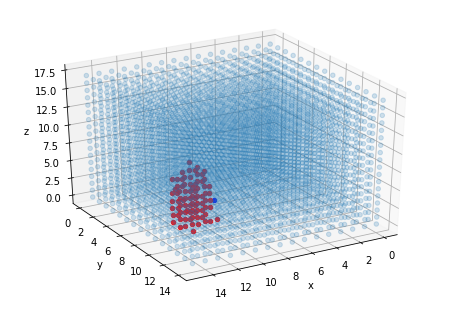

In [25]:
#X = np.load(fnames_train[0])["x"]

def plot_x_evt(evt):
    ggg = np.sum(X[evt], axis=0)
    hhh = np.nonzero(ggg)
    ax.scatter(hhh[0][0], hhh[1][0],hhh[2][0], alpha = 0.9, color='blue')
    for (i,j,k) in zip(hhh[0][1:],hhh[1][1:],hhh[2][1:]):
        #print(i,j,k)
        ax.scatter(i,j,k, alpha=0.9, color='red')
    return #ax.scatter(hhh[0],hhh[1],hhh[2], alpha=0.9,label="evt {}".format(evt))

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
#ax.scatter(l_i, l_j, l_k , alpha=0.3)
ax.scatter(lol[:,0], lol[:,1], lol[:,2], alpha=0.2)
#ax.scatter(doms["x"], doms["y"], doms["z"], color="grey", alpha=0.02)
plot_x_evt(7)
ax.grid()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(30, 60)
plt.show()


In [66]:
X = np.load("Xy_files/updown/Xy_numu_8_sel5_doms_up.npz")["x"]

In [124]:
np.nonzero(np.sum(X[7], axis=0))

(array([4, 4, 4, 4, 4, 4, 4]),
 array([8, 8, 8, 9, 9, 9, 9]),
 array([ 8,  9, 11,  0,  1,  2,  3]))

In [74]:
X.shape

(670, 75, 16, 15, 18)

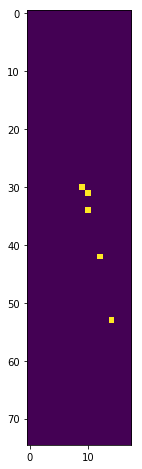

In [120]:
plt.figure(figsize=(4,8))
plt.imshow(np.sum(X[6], axis=(1,2)))

In [104]:
np.sum?

### try with TZ channel only

In [25]:
from keras.layers import Input
from keras.layers import concatenate, add
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.core import Flatten, Dense

from keras.models import Model
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta

def vgg_separate_channels(num_classes, optimizer, include_dense=False):
    """VGG inspired Convolutional Networks with multiple inputs
    
    Parameters
    ----------
    num_classes : int
        Number of classes to predict
            
    optimizer : keras.optimizers.Optimizer
        Instance of Keras optimizer to attach to the resulting network
        
    include_dense : bool (default False)
        Flag indicating wether to include a Dense Layer at the top 
        of each separate vgg-like sub-network.
    """
    
    def _conv_block(input_layer, include_dense=False):
        """VGG-inspired Convolutional Blocks"""
        
        prefix = input_layer.name.split('_')[0]

        # Block 1
        x = Conv2D(32, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block1_conv1'.format(prefix))(input_layer)
        
        x = Conv2D(32, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block1_conv2'.format(prefix))(x)
        
        x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), 
                         padding='same', name='{}_block1_pool'.format(prefix))(x)

        # Block 2
        x = Conv2D(64, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block2_conv1'.format(prefix))(x)
        
        x = Conv2D(64, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block2_conv2'.format(prefix))(x)
        
        x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), 
                         padding='same', name='{}_block2_pool'.format(prefix))(x)

        # Block 3
        x = Conv2D(64, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block3_conv1'.format(prefix))(x)
        
        x = Conv2D(64, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block3_conv2'.format(prefix))(x)
        
        x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), 
                         padding='same', name='{}_block3_pool'.format(prefix))(x)
        # Block 4
        x = Conv2D(128, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block4_conv2'.format(prefix))(x)
        
        x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2), 
                             padding='same', name='{}_block4_pool'.format(prefix))(x)
        x = Flatten()(x)
        if include_dense:
            x = Dense(512)(x)
        return x


    ZT_SHAPE = (1, 75, 18)
        
    zt_layer = Input(shape=ZT_SHAPE, name='zt_input')
    
    zt_branch = _conv_block(zt_layer, include_dense)
    
    # top
        
    x = Dense(256,activation='relu')(zt_branch)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=[zt_layer], outputs=predictions, name='vgglike')
    model.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
    return model

In [8]:
import multi_files_generator
reload(multi_files_generator)

<module 'multi_files_generator' from 'multi_files_generator.pyc'>

In [26]:
b_size = 64
epochs = 40
fargs = {'num_classes': 2, 'optimizer': Adadelta()}
vgg_sep_model = vgg_separate_channels(**fargs)

fitargs = {'steps_per_epoch': steps_per_epoch, 'epochs': epochs, 'verbose': 1, 
           'callbacks': [keras.callbacks.TensorBoard(batch_size=b_size), 
                         keras.callbacks.ModelCheckpoint("models/vgg_sep_deeper_updown_TZ_10files_"+str(b_size)+"_3x3_"+str(epochs)+"epochs.hdf5")]}
history_vgg_sep = vgg_sep_model.fit_generator(multi_files_generator.Xy_gen_TZ(fnames_train[:10], batch_size=b_size), **fitargs)


file 1 : train_test_files/Xy_train1_sel5_updown.npzEpoch 1/40

 13/243 [>.............................] - ETA: 43s - loss: 0.6873 - acc: 0.551724
file 2 : train_test_files/Xy_train2_sel5_updown.npz
 39/243 [===>..........................] - ETA: 26s - loss: 0.6702 - acc: 0.582149
file 3 : train_test_files/Xy_train3_sel5_updown.npz
 64/243 [======>.......................] - ETA: 20s - loss: 0.6394 - acc: 0.616874
file 4 : train_test_files/Xy_train4_sel5_updown.npz
 87/243 [=========>....................] - ETA: 17s - loss: 0.6176 - acc: 0.638398
file 5 : train_test_files/Xy_train5_sel5_updown.npz
113/243 [============>.................] - ETA: 14s - loss: 0.5901 - acc: 0.6569123
file 6 : train_test_files/Xy_train6_sel5_updown.npz
138/243 [================>.............] - ETA: 11s - loss: 0.5685 - acc: 0.6694148
file 7 : train_test_files/Xy_train7_sel5_updown.npz
161/243 [==================>...........] - ETA: 8s - loss: 0.5508 - acc: 0.6805172
file 8 : train_test_files/Xy_train8_sel5_u

110/243 [============>.................] - ETA: 12s - loss: 0.3473 - acc: 0.778398
file 5 : train_test_files/Xy_train5_sel5_updown.npz
134/243 [===============>..............] - ETA: 10s - loss: 0.3471 - acc: 0.7791123
file 6 : train_test_files/Xy_train6_sel5_updown.npz
159/243 [==================>...........] - ETA: 7s - loss: 0.3466 - acc: 0.7801148
file 7 : train_test_files/Xy_train7_sel5_updown.npz
184/243 [=====================>........] - ETA: 5s - loss: 0.3444 - acc: 0.7810172
file 8 : train_test_files/Xy_train8_sel5_updown.npz
207/243 [========================>.....] - ETA: 3s - loss: 0.3446 - acc: 0.7809- ETA: 5s - loss: 0.3459 196
file 9 : train_test_files/Xy_train9_sel5_updown.npz
233/243 [===========================>..] - ETA: 0s - loss: 0.3435 - acc: 0.7811221
file 10 : train_test_files/Xy_train10_sel5_updown.npz
243/243 [==============================] - 22s - loss: 0.3448 - acc: 0.7801    
Epoch 13/40
 13/243 [>.............................] - ETA: 31s - loss: 0.3367 - a

206/243 [========================>.....] - ETA: 3s - loss: 0.3313 - acc: 0.7860172
file 8 : train_test_files/Xy_train8_sel5_updown.npz
229/243 [===========================>..] - ETA: 1s - loss: 0.3315 - acc: 0.7856196
file 9 : train_test_files/Xy_train9_sel5_updown.npz
243/243 [==============================] - 24s - loss: 0.3306 - acc: 0.7860    
Epoch 24/40
 12/243 [>.............................] - ETA: 11s - loss: 0.3298 - acc: 0.7591221
file 10 : train_test_files/Xy_train10_sel5_updown.npz
 36/243 [===>..........................] - ETA: 16s - loss: 0.3342 - acc: 0.7777245
file 1 : train_test_files/Xy_train1_sel5_updown.npz
 59/243 [======>.......................] - ETA: 16s - loss: 0.3317 - acc: 0.777324
file 2 : train_test_files/Xy_train2_sel5_updown.npz
 85/243 [=========>....................] - ETA: 14s - loss: 0.3330 - acc: 0.778549
file 3 : train_test_files/Xy_train3_sel5_updown.npz
110/243 [============>.................] - ETA: 12s - loss: 0.3339 - acc: 0.782174
file 4 : tr

 34/243 [===>..........................] - ETA: 17s - loss: 0.3080 - acc: 0.7933221
file 10 : train_test_files/Xy_train10_sel5_updown.npz
 58/243 [======>.......................] - ETA: 16s - loss: 0.3146 - acc: 0.7926245
file 1 : train_test_files/Xy_train1_sel5_updown.npz
 81/243 [=========>....................] - ETA: 15s - loss: 0.3160 - acc: 0.790024
file 2 : train_test_files/Xy_train2_sel5_updown.npz
107/243 [============>.................] - ETA: 12s - loss: 0.3183 - acc: 0.789049
file 3 : train_test_files/Xy_train3_sel5_updown.npz
132/243 [===============>..............] - ETA: 10s - loss: 0.3196 - acc: 0.790074
file 4 : train_test_files/Xy_train4_sel5_updown.npz
155/243 [==================>...........] - ETA: 8s - loss: 0.3201 - acc: 0.789098
file 5 : train_test_files/Xy_train5_sel5_updown.npz
181/243 [=====================>........] - ETA: 5s - loss: 0.3206 - acc: 0.7900123
file 6 : train_test_files/Xy_train6_sel5_updown.npz
206/243 [========================>.....] - ETA: 3s -

In [22]:
from get_iterations import get_n_iterations

steps_per_epoch, n_train_events = get_n_iterations(fnames_train[10:20], 64)
print(steps_per_epoch, n_train_events)

(243, 15202)


In [23]:
b_size = 64
epochs = 40
fargs = {'num_classes': 2, 'optimizer': keras.optimizers.adadelta()}
vgg_sep_model = vgg_separate_channels(**fargs)

fitargs = {'steps_per_epoch': steps_per_epoch, 'epochs': epochs, 'verbose': 1, 
           'callbacks': [keras.callbacks.TensorBoard(batch_size=b_size), 
                         keras.callbacks.ModelCheckpoint("models/vgg_sep_2dense_grad_updown_TZ_10files_"+str(b_size)+"_3x3_"+str(epochs)+"epochs.hdf5")]}
history_vgg_sep = vgg_sep_model.fit_generator(multi_files_generator.Xy_gen_TZ(fnames_train[10:20], batch_size=b_size), **fitargs)


file 1 : train_test_files/Xy_train11_sel5_updown.npz
Epoch 1/40
 15/243 [>.............................] - ETA: 36s - loss: 0.8672 - acc: 0.553125
file 2 : train_test_files/Xy_train12_sel5_updown.npz
 40/243 [===>..........................] - ETA: 24s - loss: 0.7579 - acc: 0.541250
file 3 : train_test_files/Xy_train13_sel5_updown.npz
 61/243 [======>.......................] - ETA: 20s - loss: 0.7286 - acc: 0.548172
file 4 : train_test_files/Xy_train14_sel5_updown.npz
 85/243 [=========>....................] - ETA: 17s - loss: 0.6809 - acc: 0.583896
file 5 : train_test_files/Xy_train15_sel5_updown.npz
111/243 [============>.................] - ETA: 13s - loss: 0.6350 - acc: 0.6141121
file 6 : train_test_files/Xy_train16_sel5_updown.npz
136/243 [===============>..............] - ETA: 10s - loss: 0.5994 - acc: 0.6349146
file 7 : train_test_files/Xy_train17_sel5_updown.npz
161/243 [==================>...........] - ETA: 8s - loss: 0.5705 - acc: 0.6523171
file 8 : train_test_files/Xy_train1

 61/243 [======>.......................] - ETA: 18s - loss: 0.3272 - acc: 0.789872
file 4 : train_test_files/Xy_train14_sel5_updown.npz
 85/243 [=========>....................] - ETA: 16s - loss: 0.3333 - acc: 0.787796
file 5 : train_test_files/Xy_train15_sel5_updown.npz
110/243 [============>.................] - ETA: 13s - loss: 0.3346 - acc: 0.7860121
file 6 : train_test_files/Xy_train16_sel5_updown.npz
136/243 [===============>..............] - ETA: 10s - loss: 0.3360 - acc: 0.7851146
file 7 : train_test_files/Xy_train17_sel5_updown.npz
161/243 [==================>...........] - ETA: 8s - loss: 0.3378 - acc: 0.7843171
file 8 : train_test_files/Xy_train18_sel5_updown.npz
184/243 [=====================>........] - ETA: 5s - loss: 0.3361 - acc: 0.7848195
file 9 : train_test_files/Xy_train19_sel5_updown.npz
208/243 [========================>.....] - ETA: 3s - loss: 0.3342 - acc: 0.7864219
file 10 : train_test_files/Xy_train20_sel5_updown.npz
232/243 [===========================>..] - ET

110/243 [============>.................] - ETA: 13s - loss: 0.3264 - acc: 0.7919121
file 6 : train_test_files/Xy_train16_sel5_updown.npz
136/243 [===============>..............] - ETA: 10s - loss: 0.3283 - acc: 0.7901146
file 7 : train_test_files/Xy_train17_sel5_updown.npz
161/243 [==================>...........] - ETA: 8s - loss: 0.3300 - acc: 0.7897171
file 8 : train_test_files/Xy_train18_sel5_updown.npz
185/243 [=====================>........] - ETA: 5s - loss: 0.3285 - acc: 0.7910195
file 9 : train_test_files/Xy_train19_sel5_updown.npz
209/243 [========================>.....] - ETA: 3s - loss: 0.3266 - acc: 0.7928219
file 10 : train_test_files/Xy_train20_sel5_updown.npz
232/243 [===========================>..] - ETA: 1s - loss: 0.3260 - acc: 0.7926243
file 1 : train_test_files/Xy_train11_sel5_updown.npz
243/243 [==============================] - 23s - loss: 0.3278 - acc: 0.7909    
Epoch 24/40
 15/243 [>.............................] - ETA: 28s - loss: 0.3126 - acc: 0.785425
file 2

161/243 [==================>...........] - ETA: 8s - loss: 0.3246 - acc: 0.7928171
file 8 : train_test_files/Xy_train18_sel5_updown.npz
185/243 [=====================>........] - ETA: 5s - loss: 0.3232 - acc: 0.7933195
file 9 : train_test_files/Xy_train19_sel5_updown.npz
208/243 [========================>.....] - ETA: 3s - loss: 0.3213 - acc: 0.7953219
file 10 : train_test_files/Xy_train20_sel5_updown.npz
232/243 [===========================>..] - ETA: 1s - loss: 0.3202 - acc: 0.7960243
file 1 : train_test_files/Xy_train11_sel5_updown.npz
243/243 [==============================] - 23s - loss: 0.3220 - acc: 0.7940    
Epoch 35/40
 15/243 [>.............................] - ETA: 28s - loss: 0.3105 - acc: 0.794825
file 2 : train_test_files/Xy_train12_sel5_updown.npz
 39/243 [===>..........................] - ETA: 22s - loss: 0.3114 - acc: 0.800750
file 3 : train_test_files/Xy_train13_sel5_updown.npz
 61/243 [======>.......................] - ETA: 19s - loss: 0.3141 - acc: 0.798872
file 4 :

 62/243 [======>.......................] - ETA: 18s - loss: 0.3127 - acc: 0.801372
file 4 : train_test_files/Xy_train14_sel5_updown.npz
 86/243 [=========>....................] - ETA: 16s - loss: 0.3154 - acc: 0.800496
file 5 : train_test_files/Xy_train15_sel5_updown.npz
111/243 [============>.................] - ETA: 13s - loss: 0.3188 - acc: 0.7975121
file 6 : train_test_files/Xy_train16_sel5_updown.npz
136/243 [===============>..............] - ETA: 10s - loss: 0.3207 - acc: 0.7956146
file 7 : train_test_files/Xy_train17_sel5_updown.npz
161/243 [==================>...........] - ETA: 8s - loss: 0.3221 - acc: 0.7950171
file 8 : train_test_files/Xy_train18_sel5_updown.npz
184/243 [=====================>........] - ETA: 5s - loss: 0.3207 - acc: 0.7954195
file 9 : train_test_files/Xy_train19_sel5_updown.npz
208/243 [========================>.....] - ETA: 3s - loss: 0.3187 - acc: 0.7970219
file 10 : train_test_files/Xy_train20_sel5_updown.npz
232/243 [===========================>..] - ET

### test new generator and class_weights

In [1]:
import numpy as np

In [6]:
fnames_test = np.asarray(["train_test_files/Xy_test"+str(i+1)+"_sel5_updown.npz"for i in range(100)])
fnames_train = np.asarray(["train_test_files/Xy_train"+str(i+1)+"_sel5_updown.npz"for i in range(100)])
fnames_indx = np.asarray(["train_test_files/Xy_indx"+str(i+1)+"_sel5_updown.npz"for i in range(100)])

In [3]:
from multi_files_generator import Xy_gen_ZT_XY_cont as generator
from multi_files_generator import Xy_gen_TZ as generator_tz

Using TensorFlow backend.


In [4]:
from keras.utils import to_categorical

In [5]:
from get_iterations import get_n_iterations

In [6]:
n_files = 2

In [7]:
steps_per_epoch, n_events = get_n_iterations(fnames_train[:n_files])
print(steps_per_epoch, n_events)

(48, 3067)


In [8]:
from get_iterations import get_class_weights

In [9]:
get_class_weights(fnames_train[:n_files])

array([ 1.12674504,  0.89888628])

In [10]:
cls_weights = {i:v for i, v in enumerate(get_class_weights(fnames_train[:n_files]))}

In [11]:
from keras.layers import Input
from keras.layers import concatenate, add
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.core import Flatten, Dense

from keras.models import Model
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta

def vgg_separate_channels(num_classes, optimizer, include_dense=False):
    """VGG inspired Convolutional Networks with multiple inputs
    
    Parameters
    ----------
    num_classes : int
        Number of classes to predict
            
    optimizer : keras.optimizers.Optimizer
        Instance of Keras optimizer to attach to the resulting network
        
    include_dense : bool (default False)
        Flag indicating wether to include a Dense Layer at the top 
        of each separate vgg-like sub-network.
    """
    
    def _conv_block(input_layer, include_dense=False, pooling_size=(2, 2)):
        """VGG-inspired Convolutional Blocks"""
        
        prefix = input_layer.name.split('_')[0]

        # Block 1
        x = Conv2D(32, kernel_size=(12, 12), activation='relu', 
                   padding='same', name='{}_block1_conv1'.format(prefix))(input_layer)
        
        x = Conv2D(32, kernel_size=(12, 12), activation='relu', 
                   padding='same', name='{}_block1_conv2'.format(prefix))(x)
        
        x = AveragePooling2D(pool_size=pooling_size, strides=(2, 2), 
                         padding='same', name='{}_block1_pool'.format(prefix))(x)

        # Block 2
        x = Conv2D(64, kernel_size=(12, 12), activation='relu', 
                   padding='same', name='{}_block2_conv1'.format(prefix))(x)
        
        x = Conv2D(64, kernel_size=(12, 12), activation='relu', 
                   padding='same', name='{}_block2_conv2'.format(prefix))(x)
        
        x = AveragePooling2D(pool_size=pooling_size, strides=(2, 2), 
                         padding='same', name='{}_block2_pool'.format(prefix))(x)

        # Block 3
        x = Conv2D(128, kernel_size=(12, 12), activation='relu', 
                   padding='same', name='{}_block3_conv2'.format(prefix))(x)
        
        x = AveragePooling2D(pool_size=pooling_size, strides=(2, 2), 
                             padding='same', name='{}_block3_pool'.format(prefix))(x)
        x = Flatten()(x)
        if include_dense:
            x = Dense(512)(x)
        return x


    ZT_SHAPE = (1, 75, 18)
    XY_SHAPE = (1, 16, 15)
    
    zt_layer = Input(shape=ZT_SHAPE, name='zt_input')
    xy_layer = Input(shape=XY_SHAPE, name='xy_input')
    
    zt_branch = _conv_block(zt_layer, pooling_size=(6, 6))#, include_dense)
    xy_branch = _conv_block(xy_layer)#, include_dense)
    
    # top
    if include_dense:
        x = add([zt_branch, xy_branch], name='merge_add')
    else:
        x = concatenate([zt_branch, xy_branch], name='merge_concat')
        
    x = Dense(512, activation='relu', name='fc-1')(x)
    x = Dense(512, activation='relu', name='fc-2')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=[zt_layer, xy_layer], outputs=predictions, name='vgglike')
    model.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
    return model

In [12]:
def vgg_tz(num_classes, optimizer, include_dense=False):
    """VGG inspired Convolutional Networks with multiple inputs
    
    Parameters
    ----------
    num_classes : int
        Number of classes to predict
            
    optimizer : keras.optimizers.Optimizer
        Instance of Keras optimizer to attach to the resulting network
        
    include_dense : bool (default False)
        Flag indicating wether to include a Dense Layer at the top 
        of each separate vgg-like sub-network.
    """
    
    def _conv_block(input_layer, include_dense=False, pooling_size=(2, 2)):
        """VGG-inspired Convolutional Blocks"""
        
        prefix = input_layer.name.split('_')[0]

        # Block 1
        x = Conv2D(32, kernel_size=(12, 12), activation='relu', 
                   padding='same', name='{}_block1_conv1'.format(prefix))(input_layer)
        
        x = Conv2D(32, kernel_size=(12, 12), activation='relu', 
                   padding='same', name='{}_block1_conv2'.format(prefix))(x)
        
        x = AveragePooling2D(pool_size=pooling_size, strides=(2, 2), 
                         padding='same', name='{}_block1_pool'.format(prefix))(x)

        # Block 2
        x = Conv2D(64, kernel_size=(12, 12), activation='relu', 
                   padding='same', name='{}_block2_conv1'.format(prefix))(x)
        
        x = Conv2D(64, kernel_size=(12, 12), activation='relu', 
                   padding='same', name='{}_block2_conv2'.format(prefix))(x)
        
        x = AveragePooling2D(pool_size=pooling_size, strides=(2, 2), 
                         padding='same', name='{}_block2_pool'.format(prefix))(x)

        # Block 3
        x = Conv2D(128, kernel_size=(12, 12), activation='relu', 
                   padding='same', name='{}_block3_conv2'.format(prefix))(x)
        
        x = AveragePooling2D(pool_size=pooling_size, strides=(2, 2), 
                             padding='same', name='{}_block3_pool'.format(prefix))(x)
        x = Flatten()(x)
        if include_dense:
            x = Dense(512)(x)
        return x


    ZT_SHAPE = (1, 75, 18)
    zt_layer = Input(shape=ZT_SHAPE, name='zt_input')
    
    zt_branch = _conv_block(zt_layer, pooling_size=(6, 6))#, include_dense)
        
    x = Dense(512, activation='relu', name='fc-1')(zt_branch)
    x = Dense(512, activation='relu', name='fc-2')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=zt_layer, outputs=predictions, name='vgglike_tz')
    model.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
    return model

In [13]:
import keras

In [18]:
b_size = 64
epochs = 100
fargs = {'num_classes': 2, 'optimizer': Adadelta()}
vgg_sep_model = vgg_separate_channels(**fargs)

fitargs = {'steps_per_epoch': steps_per_epoch, 'epochs': epochs, 'verbose': 1, 'shuffle': True,
           'class_weight' : {i:v for i, v in enumerate(get_class_weights(fnames_train[:n_files]))},
           'callbacks': [#keras.callbacks.TensorBoard(batch_size=b_size), 
                         keras.callbacks.ModelCheckpoint("models/vgg_sep_updown_cls_weighted_"+str(n_files)+"files_"+str(b_size)+"_12x12_"+str(epochs)+"epochs.hdf5")]}
history_vgg_sep = vgg_sep_model.fit_generator(generator(fnames_train[:n_files], batch_size=b_size), **fitargs)


Epoch 1/100
48/48 [==============================] - 9s - loss: 0.6928 - acc: 0.5311     
Epoch 2/100
48/48 [==============================] - 8s - loss: 0.6571 - acc: 0.6336     
Epoch 3/100
48/48 [==============================] - 8s - loss: 0.5386 - acc: 0.7069     
Epoch 4/100
48/48 [==============================] - 8s - loss: 0.4889 - acc: 0.7256     
Epoch 5/100
48/48 [==============================] - 8s - loss: 0.4634 - acc: 0.7301     
Epoch 6/100
48/48 [==============================] - 8s - loss: 0.4338 - acc: 0.7444     
Epoch 7/100
48/48 [==============================] - 8s - loss: 0.4150 - acc: 0.7451     
Epoch 8/100
48/48 [==============================] - 8s - loss: 0.3999 - acc: 0.7422     
Epoch 9/100
48/48 [==============================] - 9s - loss: 0.3906 - acc: 0.7458     
Epoch 10/100
48/48 [==============================] - 8s - loss: 0.3858 - acc: 0.7441     
Epoch 11/100
48/48 [==============================] - 8s - loss: 0.3816 - acc: 0.7412     
Epoch 12

48/48 [==============================] - 8s - loss: 0.3115 - acc: 0.8152     
Epoch 92/100
48/48 [==============================] - 8s - loss: 0.3141 - acc: 0.8160     
Epoch 93/100
48/48 [==============================] - 9s - loss: 0.3184 - acc: 0.8058     
Epoch 94/100
48/48 [==============================] - 9s - loss: 0.3109 - acc: 0.8156     
Epoch 95/100
48/48 [==============================] - 8s - loss: 0.3093 - acc: 0.8089     
Epoch 96/100
48/48 [==============================] - 8s - loss: 0.2983 - acc: 0.8196     
Epoch 97/100
48/48 [==============================] - 8s - loss: 0.2959 - acc: 0.8251     
Epoch 98/100
48/48 [==============================] - 8s - loss: 0.3042 - acc: 0.8188     
Epoch 99/100
48/48 [==============================] - 8s - loss: 0.3121 - acc: 0.8145     
Epoch 100/100
48/48 [==============================] - 8s - loss: 0.2973 - acc: 0.8231     


In [19]:
predict_steps, n_test_events = get_n_iterations(fnames_test[:n_files], 64)
print(predict_steps, n_test_events)

(12, 767)


In [20]:
tot_events = 0
tot_correct = 0
data_gen = generator(fnames_test[:n_files], batch_size=64)
for i in range(predict_steps):
    (ZT_batch, XY_batch), Y_batch_true = next(data_gen)
    Y_batch_pred = vgg_sep_model.predict_on_batch([ZT_batch, XY_batch])
    y_batch_pred = np.argmax(Y_batch_pred, axis=1)
    y_batch_true = np.argmax(Y_batch_true, axis=1)
    tot_events += ZT_batch.shape[0]
    tot_correct += np.sum(y_batch_true == y_batch_pred)
    
accuracy_score = tot_correct / float(tot_events)
print(accuracy_score)
    
# y_real = np.vstack(np.asarray(ytest))
# print(y_real.shape)


# pred = vgg_sep_model.predict_generator(generator(fnames_test[:n_files]), steps=predict_steps)
# ppred = np.vstack(pred)

# predicted_y = np.argmax(pred, axis=1)
# print(predicted_y.shape)

0.726205997392


## TZ Only

In [14]:
b_size = 64
epochs = 100
fargs = {'num_classes': 2, 'optimizer': Adadelta()}
vgg_tz_net = vgg_tz(**fargs)

fitargs = {'steps_per_epoch': steps_per_epoch, 'epochs': epochs, 'verbose': 1, 'shuffle': True,
           'class_weight' : {i:v for i, v in enumerate(get_class_weights(fnames_train[:n_files]))},
           'callbacks': [#keras.callbacks.TensorBoard(batch_size=b_size), 
                         keras.callbacks.ModelCheckpoint("models/vgg_tz_updown_cls_weighted_"+str(n_files)+"files_"+str(b_size)+"_12x12_"+str(epochs)+"epochs.hdf5",)]}
history_vgg_tz = vgg_tz_net.fit_generator(generator_tz(fnames_train[:n_files], batch_size=b_size), **fitargs)




Epoch 1/100
48/48 [==============================] - 9s - loss: 0.6927 - acc: 0.5259     
Epoch 2/100
48/48 [==============================] - 6s - loss: 0.6280 - acc: 0.6320     
Epoch 3/100
48/48 [==============================] - 6s - loss: 0.5334 - acc: 0.6949     - ETA: 5s - loss: 0
Epoch 4/100
48/48 [==============================] - 6s - loss: 0.4796 - acc: 0.7276     - ETA: 1s - loss: 0.4771 - acc: 0
Epoch 5/100
48/48 [==============================] - 6s - loss: 0.4403 - acc: 0.7331     
Epoch 6/100
48/48 [==============================] - 6s - loss: 0.4127 - acc: 0.7461     
Epoch 7/100
48/48 [==============================] - 7s - loss: 0.4169 - acc: 0.7458     
Epoch 8/100
48/48 [==============================] - 6s - loss: 0.3951 - acc: 0.7409     
Epoch 9/100
48/48 [==============================] - 6s - loss: 0.3826 - acc: 0.7448     
Epoch 10/100
48/48 [==============================] - 6s - loss: 0.3808 - acc: 0.7516     
Epoch 11/100
48/48 [===========================

48/48 [==============================] - 7s - loss: 0.3240 - acc: 0.8130     
Epoch 88/100
48/48 [==============================] - 6s - loss: 0.3236 - acc: 0.8136     - ETA: 0s - loss: 0.3249 - acc: 0.81
Epoch 89/100
48/48 [==============================] - 7s - loss: 0.3160 - acc: 0.8114     
Epoch 90/100
48/48 [==============================] - 6s - loss: 0.3259 - acc: 0.7937     
Epoch 91/100
48/48 [==============================] - 7s - loss: 0.3213 - acc: 0.8165     
Epoch 92/100
48/48 [==============================] - 6s - loss: 0.3185 - acc: 0.8051     
Epoch 93/100
48/48 [==============================] - 6s - loss: 0.3143 - acc: 0.8155     
Epoch 94/100
48/48 [==============================] - 6s - loss: 0.3088 - acc: 0.8163     
Epoch 95/100
48/48 [==============================] - 6s - loss: 0.3157 - acc: 0.8109     
Epoch 96/100
48/48 [==============================] - 6s - loss: 0.3235 - acc: 0.8015     
Epoch 97/100
48/48 [==============================] - 6s - loss: 0.

In [17]:
y_true = list()
y_pred = list()

predict_steps, n_test_events = get_n_iterations(fnames_test[:n_files], 64)
print(predict_steps, n_test_events)

data_gen = generator_tz(fnames_test[:n_files], batch_size=64)
for i in range(predict_steps):
    ZT_batch, Y_batch_true = next(data_gen)
    Y_batch_pred = vgg_tz_net.predict_on_batch(ZT_batch)
    y_batch_pred = np.argmax(Y_batch_pred, axis=1)
    y_batch_true = np.argmax(Y_batch_true, axis=1)
    y_true.append(y_batch_true)
    y_pred.append(y_batch_pred)
    
y_true = np.hstack(np.asarray(y_true))
y_pred = np.hstack(np.asarray(y_pred))

(12, 767)


In [18]:

from sklearn.metrics import accuracy_score
score = accuracy_score(y_true, y_pred)
print(score)

0.702737940026


In [19]:
indices = np.where(y_true != y_pred)[0]

In [168]:
y_pred[indices]

array([1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 1])

In [20]:
indices.shape

(228,)

In [21]:
indx_test_1 = np.load("train_test_files/Xy_indx1_sel5_updown.npz")["test"]
indx_test_2 = np.load("train_test_files/Xy_indx2_sel5_updown.npz")["test"]

In [22]:
indx_test_1.shape, indx_test_2.shape

((374,), (393,))

In [23]:
indices_1 = indices[np.where(indices<374)[0]]

In [24]:
indices_2 = indices[np.where(indices>=374)[0]]-374

In [7]:
X_1, y_1 = np.load(fnames_test[0])["x"], np.load(fnames_test[0])["y"]
X_2, y_2 = np.load(fnames_test[1])["x"], np.load(fnames_test[1])["y"]

In [26]:



X_1[indices_1].shape

(104, 75, 16, 15, 18)

In [27]:
X_2[indices_2].shape

(124, 75, 16, 15, 18)

In [13]:
X = X_1[indices_1]
y = y_1[indices_1]
gen_wrong_evts =(i for i in range(X.shape[0]) )

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

0
(5, 9)


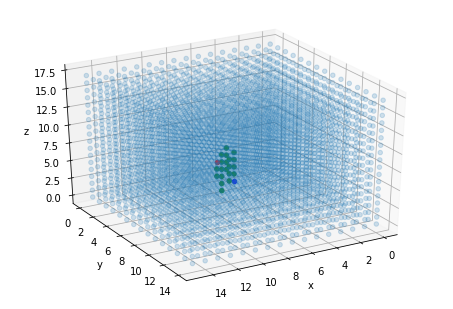

In [49]:
def plot_x_evt(evt):
    hhh = np.nonzero(X[evt])
    print(hhh[3][0], hhh[3][-1])
    ax.scatter(hhh[1][0], hhh[2][0],hhh[3][0], alpha = 0.9, color='blue')
    ax.scatter(hhh[1][1:-1], hhh[2][1:-1], hhh[3][1:-1], alpha=0.9, color='green')
    ax.scatter(hhh[1][-1], hhh[2][-1],hhh[3][-1], alpha = 0.9, color='red')
    
    return

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
#ax.scatter(l_i, l_j, l_k , alpha=0.3)
ax.scatter(lol[:,0], lol[:,1], lol[:,2], alpha=0.2)
#ax.scatter(doms["x"], doms["y"], doms["z"], color="grey", alpha=0.02)

evt = next(gen_wrong_evts)
print(y[evt])
plot_x_evt(evt)
ax.grid()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(30, 60)
plt.show()


0


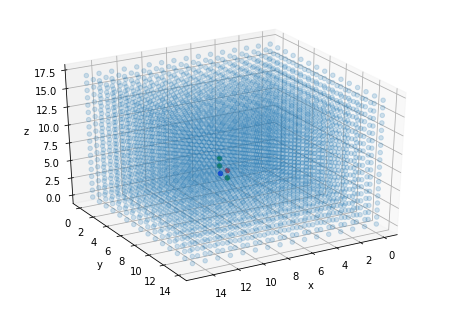

In [110]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(lol[:,0], lol[:,1], lol[:,2], alpha=0.2)

evt = next(gen_wrong_evts)
print(y[evt])
plot_x_evt(evt)
ax.grid()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(30, 60)
plt.show()

In [1]:
X.shape

NameError: name 'X' is not defined

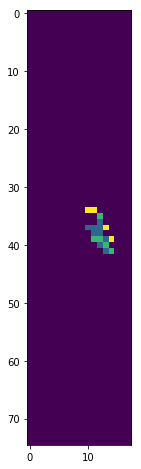

In [111]:
plt.figure(figsize=(4,8))
plt.imshow(np.sum(X[0], axis=(1,2)))

In [172]:
X_1[indices_1][2].shape, y_1[indices_1][2]

((75, 16, 15, 18), 1)

In [2]:
import numpy as np

In [3]:
indices_1 =np.array([  0,   1,   2,   5,  10,  19,  23,  28,  35,  37,  40,  46,  52,
        53,  57,  63,  66,  68,  72,  74,  82,  88,  90,  94, 103, 104,
       106, 108, 109, 114, 116, 119, 124, 127, 129, 134, 135, 138, 140,
       142, 145, 153, 154, 161, 164, 170, 176, 177, 178, 183, 185, 187,
       188, 192, 194, 198, 199, 202, 213, 219, 220, 222, 227, 228, 230,
       233, 235, 242, 243, 246, 250, 252, 256, 260, 263, 264, 266, 268,
       272, 273, 274, 275, 278, 283, 284, 285, 287, 295, 304, 305, 307,
       310, 321, 326, 329, 333, 337, 340, 349, 356, 358, 359, 363, 364])

In [4]:
import plotly.plotly as py
import plotly.graph_objs as go

In [112]:
def scatter_plotly(X, evt):
    hhh = np.nonzero(X[evt])
    
    def first():
               
        trace = go.Scatter3d(x = hhh[1][0],
                             y = hhh[2][0],
                             z = hhh[3][0],
                             mode='markers',
                             marker=dict(color='blue', 
                                         size=4, symbol='circle',
                                         line=dict(width=1), opacity=0.9,
                                         ))
        return trace
    
    def last():
        
        trace = go.Scatter3d(x = hhh[1][-1],
                             y = hhh[2][-1],
                             z = hhh[3][-1],
                             mode='markers',
                             marker=dict(color='red', 
                                         size=4, symbol='circle',
                                         line=dict(width=1), opacity=0.9,
                                         ))
        return trace
    
    def middle():
        
        trace = go.Scatter3d(x = hhh[1][1:-1],
                             y = hhh[2][1:-1],
                             z = hhh[3][1:-1],
                             mode='markers',
                             marker=dict(color='green', 
                                         size=4, symbol='circle',
                                         line=dict(width=1), opacity=0.9,
                                         ))
        return trace
  
    trace1 = go.Scatter3d(x= lol[:,0],
                          y= lol[:,1],
                          z= lol[:,2],
        mode='markers', marker=dict(size=6, line=dict(color='rgb(127, 127, 127, 0.14)', width=1),opacity=0.2))
    
    layout = go.Layout(
                        scene = dict(
                        xaxis = dict(
                             backgroundcolor="rgb(200, 200, 230)",
                             gridcolor="rgb(255, 255, 255)",
                             showbackground=True,
                             zerolinecolor="rgb(255, 255, 255)",),
                        yaxis = dict(
                            backgroundcolor="rgb(230, 200,230)",
                            gridcolor="rgb(255, 255, 255)",
                            showbackground=True,
                            zerolinecolor="rgb(255, 255, 255)"),
                        zaxis = dict(
                            backgroundcolor="rgb(230, 230,200)",
                            gridcolor="rgb(255, 255, 255)",
                            showbackground=True,
                            zerolinecolor="rgb(255, 255, 255)",),),
                        width=700,
                        margin=dict(
                        r=10, l=10,
                        b=10, t=10)
                      )
    data = [trace1, first(), middle(), last()]
    fig = go.Figure(data=data, layout= layout)
    return fig
                 

In [113]:
evt = next(gen_wrong_evts)
fig = scatter_plotly(X,evt)
print(y[evt])
py.iplot(fig)

1


1


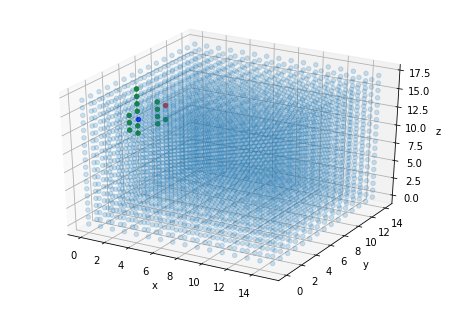

In [115]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(lol[:,0], lol[:,1], lol[:,2], alpha=0.2)

print(y[evt])
plot_x_evt(evt)
ax.grid()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#ax.view_init(30, 60)
plt.show()

In [116]:
evt = next(gen_wrong_evts)
fig = scatter_plotly(X,evt)
print(y[evt])
py.iplot(fig)

0
